In [17]:
import itertools as it
import numpy as np
import jax.numpy as jnp
import jax.random as random
import geometricconvolutions.geometric as geom
import geometricconvolutions.utils as utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
D = 2
N = 3
img_k = 1
max_k = 2
group_operators = geom.make_all_operators(D)
print(len(group_operators))

8


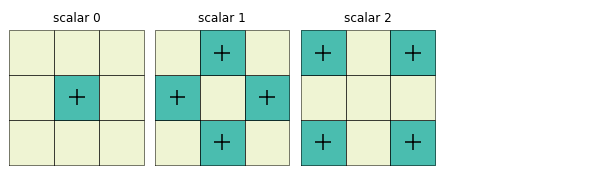

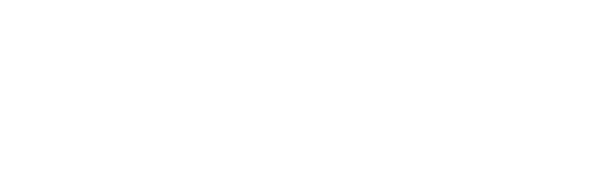

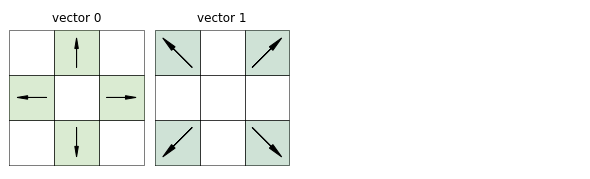

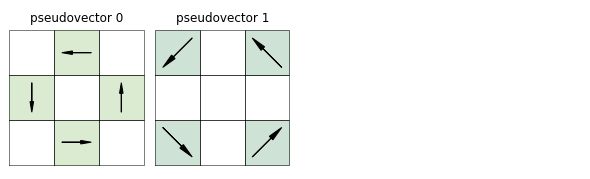

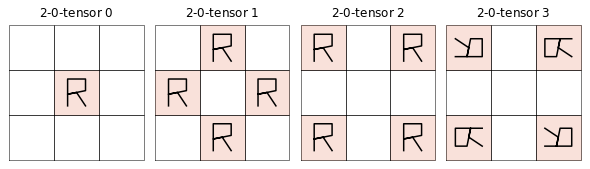

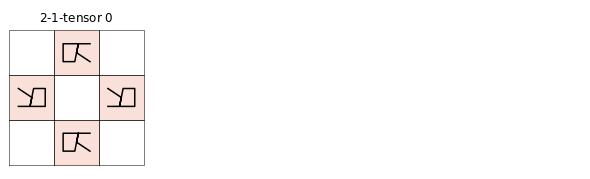

In [19]:
allfilters, maxn = geom.get_invariant_filters([N], range(max_k+1), [0,1], D, group_operators, scale='one')
for key in allfilters.keys():
    D, M, k, parity = key
    names = ["{} {}".format(geom.tensor_name(k, parity), i) for i in range(len(allfilters[key]))]
    utils.plot_filters(allfilters[key], names, maxn[(D, M)])

In [20]:
filter_list = list(it.chain(*list(allfilters.values())))
print(len(filter_list))

12


In [21]:
# Make an N side length, parity=0 geometric vector image on a D-torus
key = random.PRNGKey(0)
vector_images = []
if (N == 3):
    num_images = 3
elif (N == 5):
    num_images = 7
    
for _ in range(num_images):
    key, subkey = random.split(key)
    vector_images.append(
        geom.GeometricImage(random.normal(subkey, shape=((N,)*D + (D,)*img_k)), 0, D).normalize()
    )

In [22]:
def quadratic_filter(img, c1, c2, c3):
    return (img.convolve_with(c1) * img.convolve_with(c2)).convolve_with(c3)

In [34]:
def getVectorImgs(vector_image, extra_images = []):
    vector_images = []
    for c1_idx, c2_idx, c3_idx in it.combinations(range(len(filter_list)), 3):
        print(c1_idx, c2_idx, c3_idx)
        c1 = filter_list[c1_idx]
        c2 = filter_list[c2_idx]
        c3 = filter_list[c3_idx]

        #conditions suitable for a sequence of kronecker contractions
        if (
            ((c1.k + c2.k + c3.k + vector_image.k)%2 == 0) and 
            ((c1.parity + c2.parity + c3.parity + vector_image.parity)%2 == 0)
        ):
            img = quadratic_filter(vector_image, c1, c2, c3)

            for idxs in geom.get_contraction_indices(img.k, vector_image.k):

                img_contracted = img.multicontract(idxs)
                assert img_contracted.shape() == vector_image.shape()

                long_image = img_contracted.data.flatten()
                for extra_image in extra_images:
                    extra_img = quadratic_filter(extra_image, c1, c2, c3)
                    extra_img_data = extra_img.multicontract(idxs).data.flatten()
                    long_image = jnp.concatenate((long_image, extra_img_data))

                vector_images.append(long_image)
                
    return jnp.array(vector_images)

In [35]:
vector_image, *extra_images = vector_images
datablock = getVectorImgs(vector_image, extra_images)

0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
0 4 11
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 5 11
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 6 10
0 6 11
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 7 10
0 7 11
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 8 9
0 8 10
0 8 11
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 9 10
0 9 11
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 10 10
0 10 11
0 11 0
0 11 1
0 11 2
0 11 3
0 11 4
0 11 5
0 11 6
0 11 7
0 11 8
0 11 9
0 11 10
0 11 11
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
1 2 11
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 3 10
1 3 11
1 4 0
1 4 1
1 

In [36]:
print(datablock.shape)
print(jnp.unique(jnp.around(datablock, decimals=4), axis=0).shape)

(8952, 54)
(918, 54)


In [37]:
u, s, v = jnp.linalg.svd(jnp.unique(datablock, axis=0))
print("there are", np.sum(s > 10*geom.TINY), "different images")

there are 40 different images
